In [107]:
# -*- coding: utf-8 -*-

#Import des modules Python destinés au Machine Learning
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
from scipy.stats import chi2_contingency

Import des jeux de données d'entraînement et de déploiement

La première colonne ID est en double dans chaque des deux DataFrames. On supprime donc le doublon et on renomme la 1ère colonne.

In [72]:
train=pd.read_csv("/Users/imsd/Desktop/COURS/Machine learning/bank-train.csv",sep=";")
test=pd.read_csv("/Users/imsd/Desktop/COURS/Machine learning/bank-test.csv",sep=";")

train = train.rename(columns={'Unnamed: 0': 'ID'})
test = test.rename(columns={'Unnamed: 0': 'ID'})

del train['id']
del test['id']

## I) Diagnostic des données


Q1 - On distingue tout d'abord les variables quantitatives et catégorielles dans deux différentes listes.

In [10]:
num=[i for i in dict(train.dtypes) if dict(train.dtypes)[i] in ['float64', 'int64']]
print('Variables quantitatives : \n \n', num)

print('\n')
quali=[i for i in dict(train.dtypes) if dict(train.dtypes)[i] not in ['float64', 'int64']]
print('Variables qualitatives : \n \n ', quali)

Variables quantitatives : 
 
 ['ID', 'age', 'balance', 'day', 'campaign', 'pdays', 'previous', 'y', 'beginning', 'end', 'mono']


Variables qualitatives : 
 
  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


Q2 -  On cherche ensuite à vérifier que les distributions sont bien identiques pour le train et le test (à quelques points de pourcentage près à chaque fois).
On s'intéresse tout d'abord aux distributions des variables qualitatives.

- 1ère méthode: on représente la distribution des variables sous forme de graphiques et on compare (Distribution Train en bleu, Test en vert)


- 2e méthode : on peut également construire un DataFrame avec l'ensemble des modalités des variables qualitatives et leurs fréquences respectives dans le Train et dans le Test. Cela est tout de même moins lisible. L'objectif est ensuite de réaliser des tests de proportion afin de voir - pour chaque modalité de chaque variable - si la proportion dans la population Train est significativement différente (ou non) de la proportion dans la population Test.

On remarque que les distributions pour chaque variable qualitative sont quasiment identiques

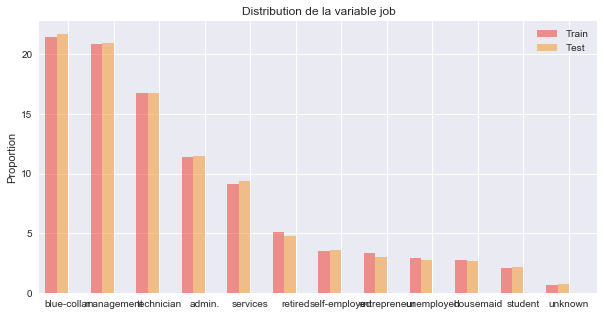

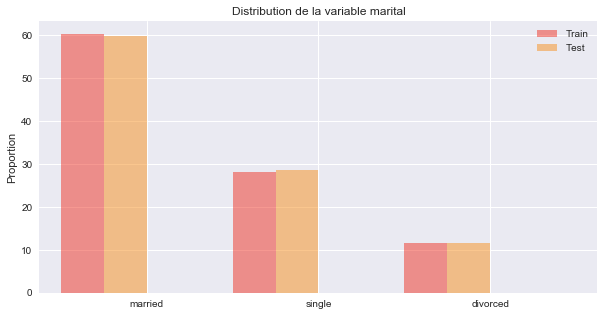

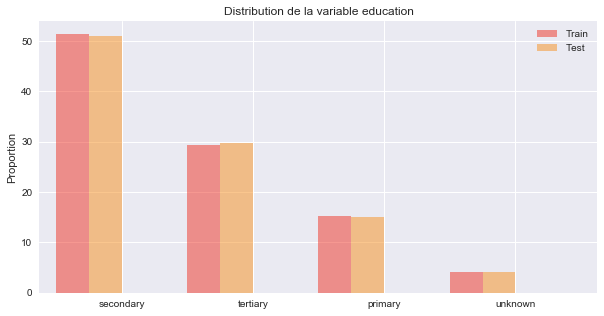

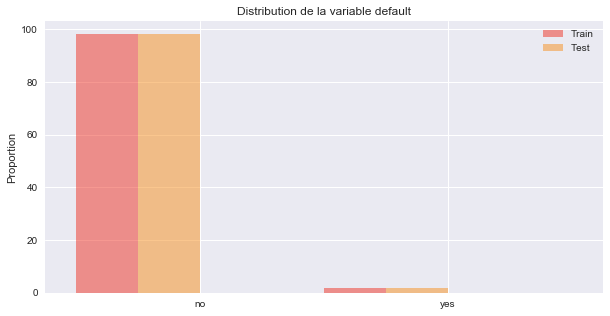

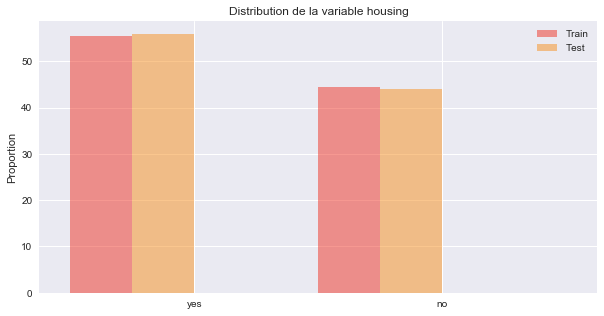

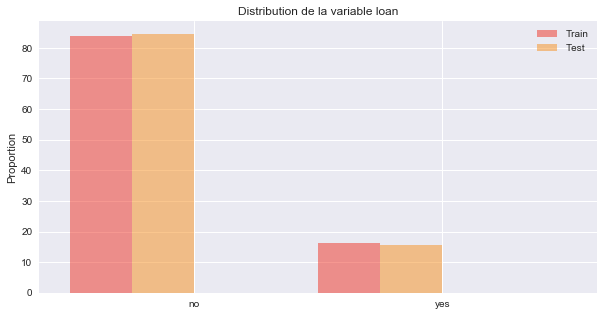

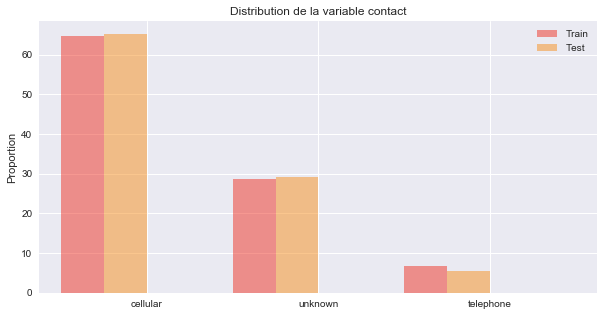

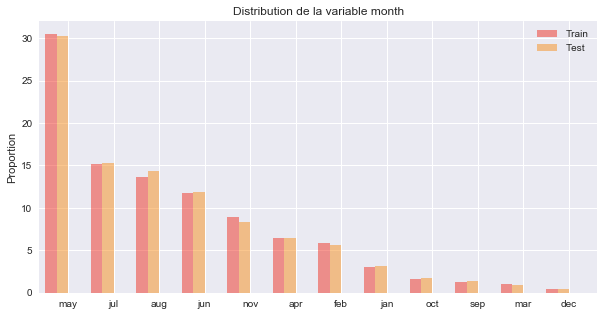

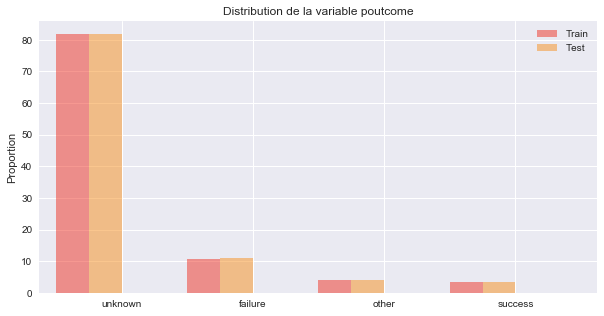

In [12]:
#series_train = []
#series_test = []
#for i in quali:
#    series_train.append(train[i].value_counts()*100/len(train))
#    series_test.append(test[i].value_counts()*100/len(test))


#METHODE 1
for elt in quali:
    pos = list(range(len(train[elt].value_counts().index)))
    width = 0.25

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(10,5))

    plt.bar(pos,
            (train[elt].value_counts().values / len(train[elt]) * 100),
            width,
            alpha=0.5,
            color='#EE3224',
            label='train')

    plt.bar([p + width for p in pos],
            (test[elt].value_counts().values / len(test[elt]) * 100),
            width,
            alpha=0.5,
            color='#F78F1E',
            label='test')

    # Set the y axis label
    ax.set_ylabel('Proportion')

    # Set the chart's title
    ax.set_title('Distribution de la variable ' + elt)

    # Set the position of the x ticks
    ax.set_xticks([p + 1.5 * width for p in pos])

    # Set the labels for the x ticks
    ax.set_xticklabels(train[elt].value_counts().index.tolist())

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*4)

    # Adding the legend and showing the plot
    plt.legend(['Train', 'Test'], loc='upper right')


    plt.show()

In [21]:
# METHODE 2
serie_train = pd.Series()
serie_test = pd.Series()
for i in range(len(serie_train)):
    serie_train = serie_train.append(series_train[i])
    serie_test = serie_test.append(series_test[i])
    
    
pd.DataFrame({'Train': serie_train, 'Test': serie_test})

,Test,Train


On vérifie maintenant que les distributions Train & Test sur les variables quantitatives sont également identiques.

C:\Users\imsd\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


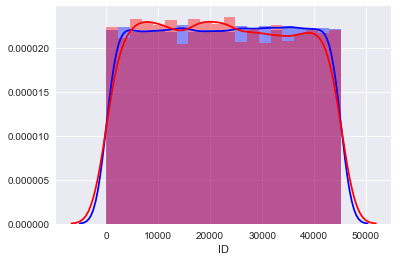

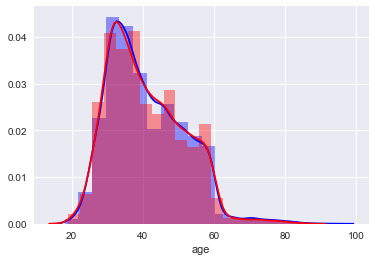

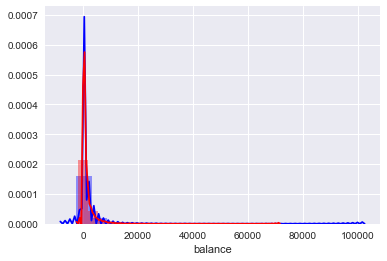

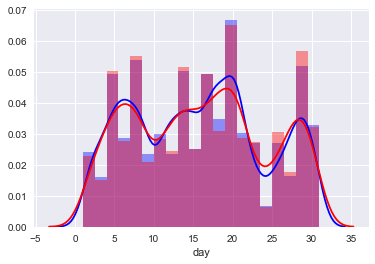

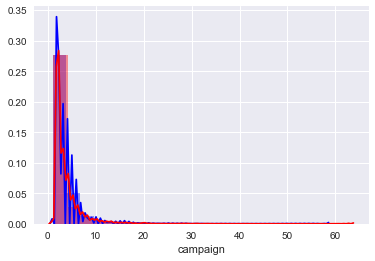

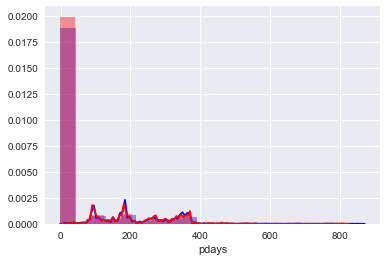

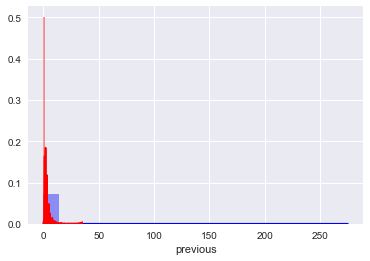

ValueError: max must be larger than min in range parameter.

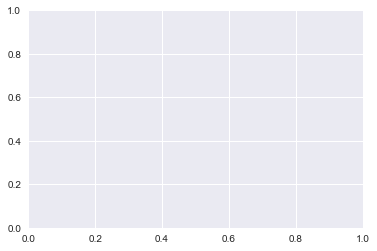

In [22]:
for elt in num:
    lm = sns.distplot(train[elt], color="b", bins=20, label="Train")
    sns.distplot(test[elt], color="r", bins=20, label="Test")
#    axes = lm.axes
#    axes.set_xlim(train[elt].quantile(0.05),train[elt].quantile(0.95))
    plt.show()

    Q3 - On cherche maintenant à étudier la corrélation entre les différentes variables. Pour cela, la fonction scatter_plot nous est utile. Elle construit un scatterplot entre paires de variables. On remarque que certaines variables quantitatives sont binaires, ce qui rendre le scatterplot peu lisible. On préfère donc ici les écarter pour les analyser différemment. Globalement, même sur les quantativés restantes, les scatterplots sont peu lisibles. On remarque néanmoins:

- qu'il y a une relation linéaire entre beginning & end. Cela signifie que la durée des appels est quasiment constante.
- que la distribution de l'âge s'approche d'une distribution normale.
- que la variable 'balance' est potentiellement liée à la variable âge 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x134ef8630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1377790f0>]], dtype=object)

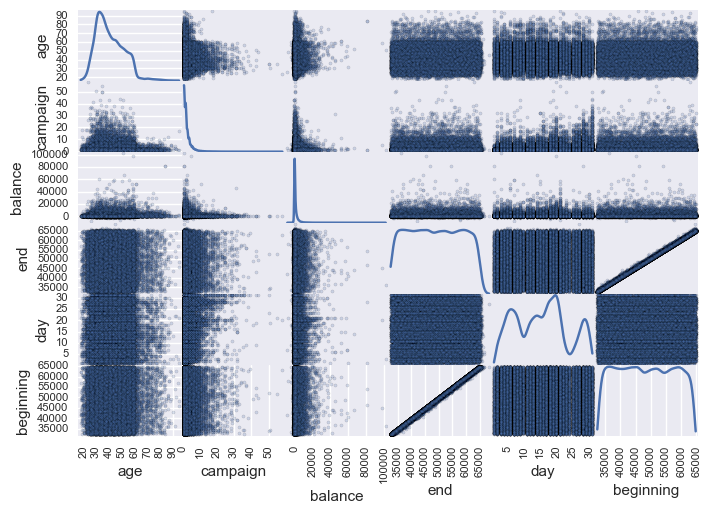

In [158]:
from pandas.tools.plotting import scatter_matrix
train_quanti = train[[elt for elt in num if elt not in ['ID','pdays','previous','mono']]]
scatter_matrix(train_quanti, alpha=0.2, diagonal='kde')

#### Question 4:
Dans cette partie, on donne un aperçu sur l'échantillon qui nous a été fournis en mettant en avant quelques chiffres représentatifs: 
- Dans le graphe ci-dessous on remarque que globalement les non propriétaires ont un revenu moyen légèrement plus grand que les propriétaires. Cet écart peut s'expliquer pricipalement par des phénomènes sociaux-économique.

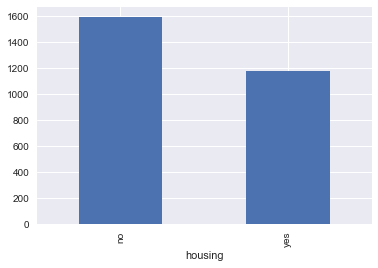

In [24]:
balance_habitat=train.groupby('housing')['balance'].mean()
balance_habitat.plot.bar(x='housing', y='balance')

- On remarque clairement qu'il y a cinq professions majoritaires, avec un pic pour les manageurs qui d’ailleurs, ont principalement eu une éducation tertiaire, ce qui est assez naturel étant donné les exigences imposés par le métier. 
Tandis que les titulaires du diplôme de fin d’études secondaires ou d’autres qualifications s'orientent vers d'autres métiers plus techniques comme les cols bleus

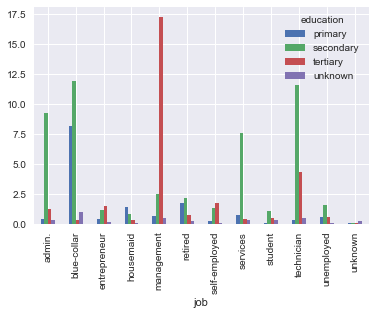

In [27]:
pop_etu_prof=train.groupby([train['job'],train['education']])
count= pop_etu_prof.size().unstack().fillna(0)*100/len(train)
count.plot(kind='bar', stacked=False)#agrandir le graphique ou mettre stacked=True

- La population ce répartit particulièrement bien dans notre cas,on remarque un certain équilibre entre les diffèrentes classes, ce qui nous apportera plus de précision sur notre échantillon.

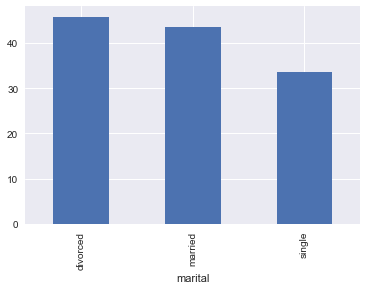

In [29]:
mean_age_couple=train.groupby('marital')['age'].mean()
mean_age_couple.plot.bar()

# 2) Analyse bivariée

### Question 1:
pour confirmer nos résultats du scatter plot vu précédamment nous déduisons la matrice de corrélation en utilisant la méthode de spearman.

La corrélation linéaire quantifie l'intencité d'une relation linéaire entre deux variables numériques. Lorsqu'il n'y a pas de corrélation entre deux variables, il n'y a pas de tendance à ce que les valeurs d'une quantité augmentent ou diminuent avec les valeurs de la deuxième quantité.


In [73]:
cible= {"yes": 1,"no": 0}
train["y"] =train["y"].map(cible)
train['y']=train['y'].apply(pd.to_numeric, errors='coerce')
train['y']=train['y'].apply(np.int64)

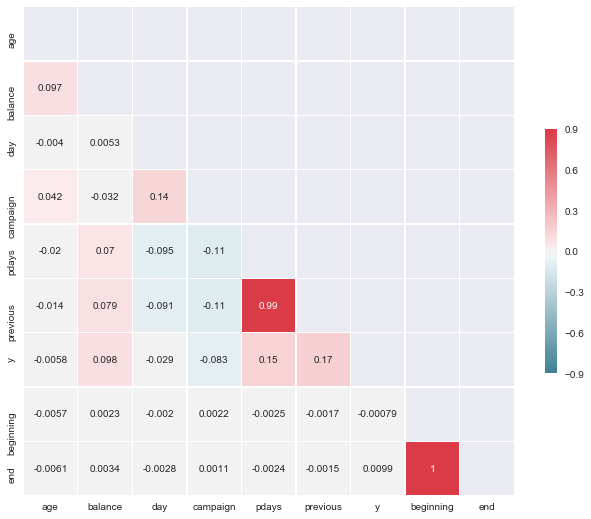

In [78]:

#Etant donné qu'il y a certaines variables numériques avec lesquelles une corrélation n'a pas de valeur ajoutée, on les supprimes
lis=['Unnamed: 0','ID','mono']
newlist = []
[newlist.append(x) for x in num if x not in lis]
#générer un masque pour du triange supérieur de la matrice
cor = train[newlist].corr("spearman")
mask1 = np.zeros_like(cor, dtype=np.bool)
mask1[np.triu_indices_from(mask)] = True

# config de figure matplotlib 
f, ax = plt.subplots(figsize=(11, 9))

# choix colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask
# affichage de la heatMap
sns.heatmap(cor, annot=True,mask=mask1, cmap=cmap, vmax=.9, 
            square=False,linewidths=.3, cbar_kws={"shrink": .5}, ax=ax)
#with sns.axes_style("dark"):ax = sns.heatmap(cor, cbar_kws={"shrink": .5},cmap=cmap,mask=mask1, vmax=.3, square=True)
    


- Le diagramme en baton empilé est un graphique utile pour visualiser la relation entre deux variables catégorielles.
Il compare le pourcentage que chaque catégorie d'une variable contribue à un total à travers les catégories de la deuxième variable.


- Le test du chi deux peut être utilisé pour déterminer l'association entre les variables catégorielles. Le test est basé sur la différence entre les fréquences attendues et les fréquences observées dans une ou plusieurs catégories de la table des fréquences. 
La distribution du chi deux renvoie une probabilité  et le degré de liberté. Une probabilité de zéro montre une dépendance complète entre deux variables catégorielles et une probabilité de un signifie que deux variables catégorielles sont complètement indépendantes. 
Dans le package scipy.stats il existe une fonction chi2_contingency qui permet de calculer ce test a partir d'une table de contingence. 

marital


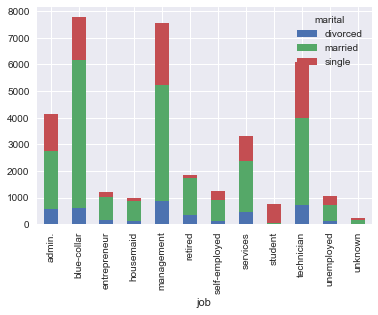

 Pearson Chi-squared test 

X-squared= 3059.95911964 	df = 22 	p-value= 0.0 

education


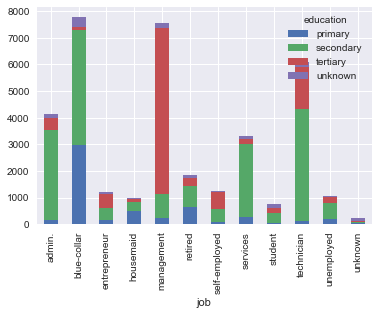

 Pearson Chi-squared test 

X-squared= 22740.9399523 	df = 33 	p-value= 0.0 

default


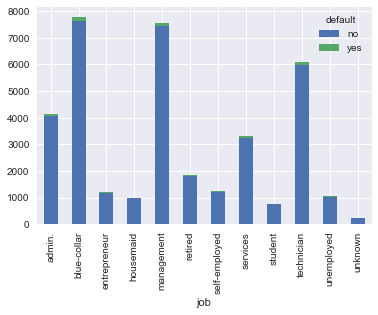

 Pearson Chi-squared test 

X-squared= 41.8228826764 	df = 11 	p-value= 1.73811809455e-05 

housing


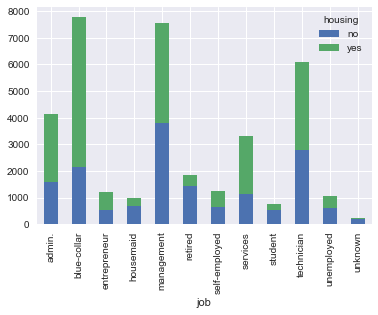

 Pearson Chi-squared test 

X-squared= 2830.87561492 	df = 11 	p-value= 0.0 

loan


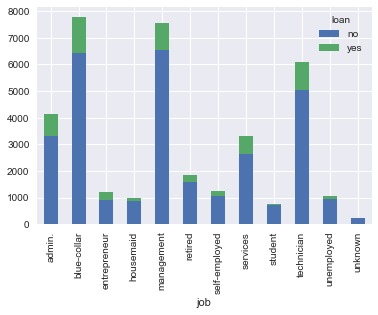

 Pearson Chi-squared test 

X-squared= 409.808170102 	df = 11 	p-value= 5.05828655617e-81 

poutcome


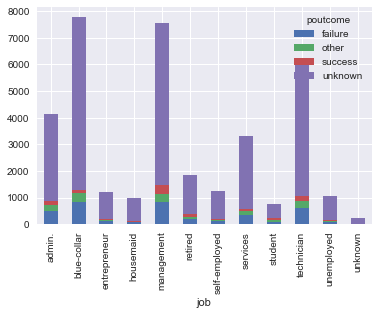

 Pearson Chi-squared test 

X-squared= 470.891479214 	df = 33 	p-value= 6.69564967839e-79 

education


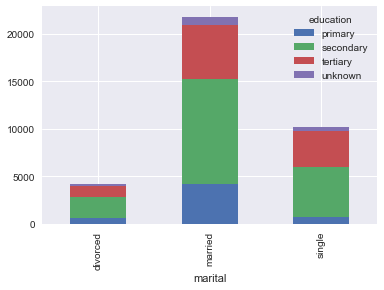

 Pearson Chi-squared test 

X-squared= 1054.99126376 	df = 6 	p-value= 1.13923209148e-224 

default


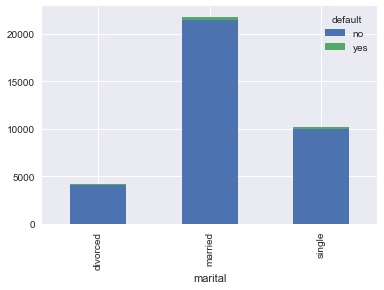

 Pearson Chi-squared test 

X-squared= 14.4825746375 	df = 2 	p-value= 0.000716388945347 

housing


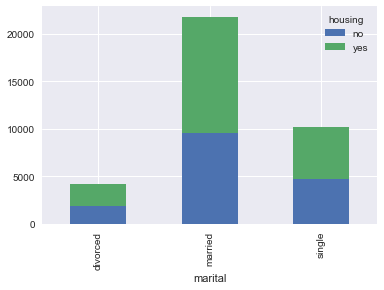

 Pearson Chi-squared test 

X-squared= 13.610973803 	df = 2 	p-value= 0.00110768070841 

loan


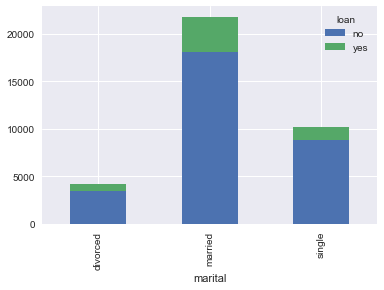

 Pearson Chi-squared test 

X-squared= 86.287493232 	df = 2 	p-value= 1.83193017402e-19 

poutcome


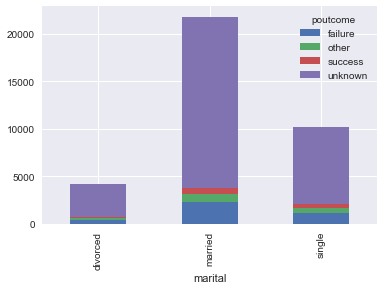

 Pearson Chi-squared test 

X-squared= 56.2168725812 	df = 6 	p-value= 2.63136588433e-10 

default


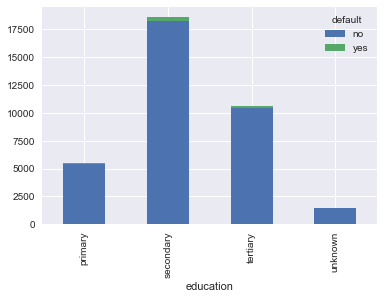

 Pearson Chi-squared test 

X-squared= 10.0487234863 	df = 3 	p-value= 0.0181564761977 

housing


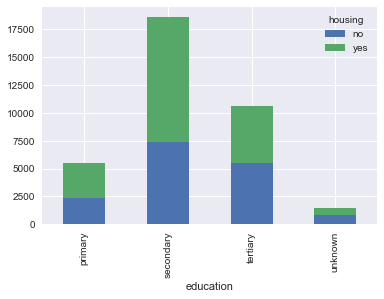

 Pearson Chi-squared test 

X-squared= 510.258169811 	df = 3 	p-value= 2.85449927053e-110 

loan


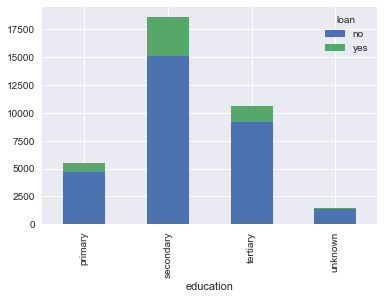

 Pearson Chi-squared test 

X-squared= 241.243945217 	df = 3 	p-value= 5.12271671574e-52 

poutcome


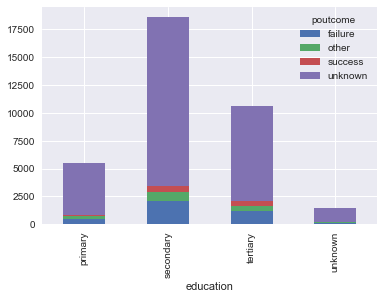

 Pearson Chi-squared test 

X-squared= 145.89210284 	df = 9 	p-value= 6.24946258729e-27 

housing


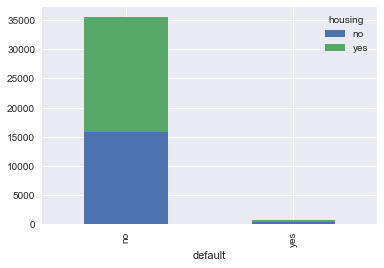

 Pearson Chi-squared test 

X-squared= 3.50179755734 	df = 1 	p-value= 0.0613022569934 

loan


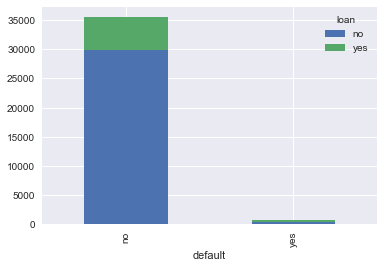

 Pearson Chi-squared test 

X-squared= 222.870661 	df = 1 	p-value= 2.13913028436e-50 

poutcome


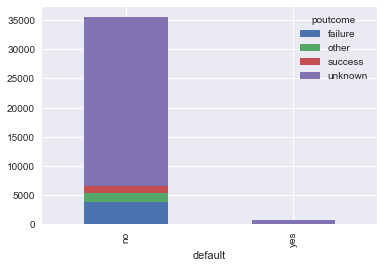

 Pearson Chi-squared test 

X-squared= 60.5557547629 	df = 3 	p-value= 4.47203054368e-13 

loan


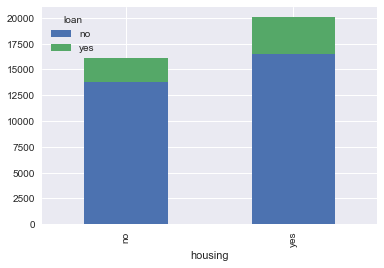

 Pearson Chi-squared test 

X-squared= 73.747647666 	df = 1 	p-value= 8.87700087199e-18 

poutcome


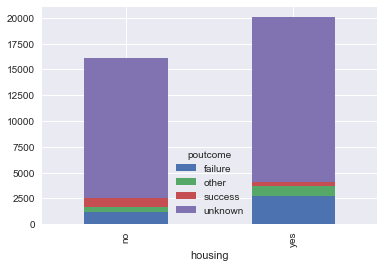

 Pearson Chi-squared test 

X-squared= 740.309204463 	df = 3 	p-value= 3.81180689263e-160 

poutcome


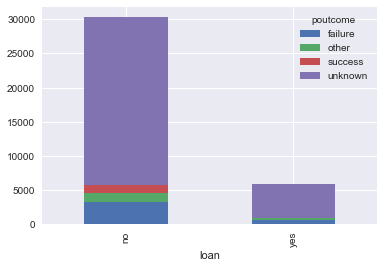

 Pearson Chi-squared test 

X-squared= 106.303161965 	df = 3 	p-value= 6.85179114463e-23 



In [109]:
tmp  = quali.copy()
tmp1 = quali.copy()
for val in quali :
    if val in ['contact','month']: continue
    #tmp = tmp.remove(val)
    tmp.remove(val)
    tmp
    for val1 in tmp:
        if val1 in ['contact','month']: continue
        print(val1)
        ct = pd.crosstab(train[val],train[val1])
        ct.plot(kind='bar', stacked=True)
        plt.show()
        chi2, p, dof, ex  = chi2_contingency(ct)
        print(" Pearson Chi-squared test \n")
        print("X-squared=",chi2,"\tdf =",dof,"\tp-value=",p,"\n")